In [17]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [18]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import peakutils
import locate
import farwave
import time

from scipy import signal

In [19]:
%matplotlib notebook

In [20]:
%sql sqlite:///schema/sunday_cardboard.db

u'Connected: None@schema/sunday_cardboard.db'

In [21]:
result = %sql select * from experiment

print result

Done.
+----+------------+-----+-----+-------+-------+---------+
| id |  datetime  |  x  |  y  | x_hat | y_hat | comment |
+----+------------+-----+-----+-------+-------+---------+
| 1  | 1489359605 | 0.0 | 0.0 |  0.0  |  0.0  |    0    |
| 2  | 1489359611 | 0.0 | 0.0 |  0.0  |  0.0  |    0    |
| 3  | 1489359616 | 0.0 | 0.0 |  0.0  |  0.0  |    0    |
| 4  | 1489359854 | 0.0 | 0.0 |  0.0  |  0.0  |    30   |
| 5  | 1489359860 | 0.0 | 0.0 |  0.0  |  0.0  |    30   |
| 6  | 1489359865 | 0.0 | 0.0 |  0.0  |  0.0  |    30   |
| 7  | 1489360126 | 0.0 | 0.0 |  0.0  |  0.0  |    60   |
| 8  | 1489360132 | 0.0 | 0.0 |  0.0  |  0.0  |    60   |
| 9  | 1489360138 | 0.0 | 0.0 |  0.0  |  0.0  |    60   |
| 10 | 1489360279 | 0.0 | 0.0 |  0.0  |  0.0  |    90   |
| 11 | 1489360306 | 0.0 | 0.0 |  0.0  |  0.0  |    90   |
| 12 | 1489360313 | 0.0 | 0.0 |  0.0  |  0.0  |    90   |
| 13 | 1489360320 | 0.0 | 0.0 |  0.0  |  0.0  |    90   |
| 14 | 1489360731 | 0.0 | 0.0 |  0.0  |  0.0  |   120   |
| 15 | 1

In [22]:
result = %sql select * from array

print result

Done.
+---------------+----------+-----+-----+-----------------+---------------+
| experiment_id | array_id |  x  |  y  |        r        |     theta     |
+---------------+----------+-----+-----+-----------------+---------------+
|       1       |    0     | 0.0 | 0.0 |  1.05210268375  | 1.04719747648 |
|       2       |    0     | 0.0 | 0.0 |  0.31467246795  | 1.04719749097 |
|       3       |    0     | 0.0 | 0.0 |   0.6910774843  | 1.04719748243 |
|       4       |    0     | 0.0 | 0.0 | -0.530589770569 | 10.4719754469 |
|       5       |    0     | 0.0 | 0.0 |  8.45426757924  | 1.04719746242 |
|       6       |    0     | 0.0 | 0.0 |  0.765869795211 | 1.04719748093 |
|       7       |    0     | 0.0 | 0.0 |  -300.437500932 | 15.1134800572 |
|       8       |    0     | 0.0 | 0.0 |  0.783129179312 |  1.0471974806 |
|       9       |    0     | 0.0 | 0.0 |  -168.329720387 | 15.1791568321 |
|       11      |    0     | 0.0 | 0.0 |  0.203466882724 | 5.23598748829 |
|       12      |  

In [23]:
cur_experiment_id = 26
result = %sql select data from mic where experiment_id = :cur_experiment_id and array_id = 0

mic_0 = np.array(result[0][0])
mic_1 = np.array(result[1][0])
mic_2 = np.array(result[2][0])

Done.


<IPython.core.display.Javascript object>


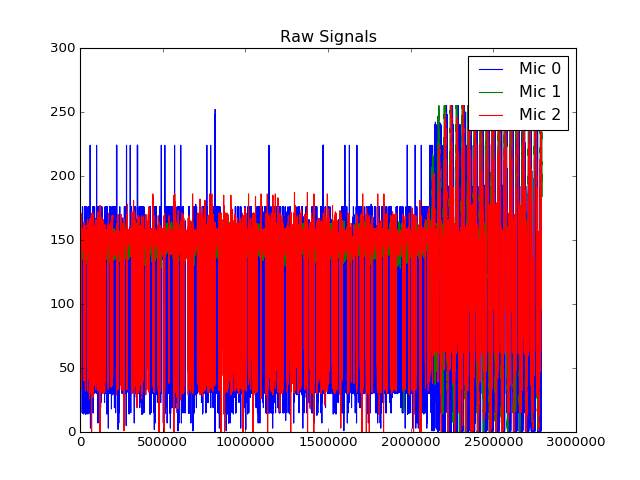

In [24]:
plt.figure()
plt.plot(mic_0, label='Mic 0')
plt.plot(mic_1, label='Mic 1')
plt.plot(mic_2, label='Mic 2')
plt.title('Raw Signals')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


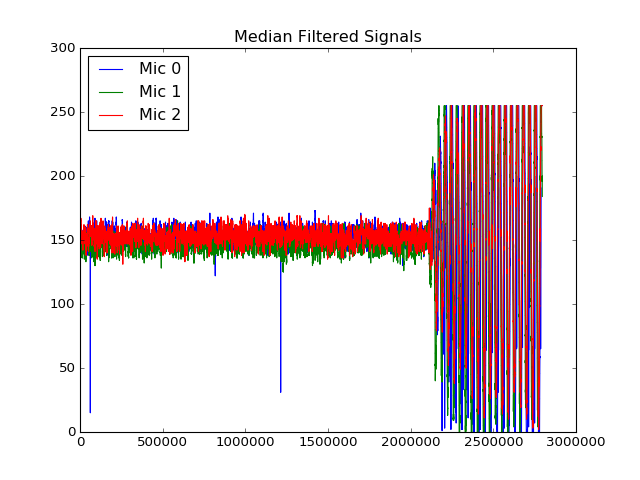

In [25]:
# Plot median filtered signal
mic_0_med = locate.median_filter(mic_0, window=21)
mic_1_med = locate.median_filter(mic_1, window=21)
mic_2_med = locate.median_filter(mic_2, window=21)

plt.figure()
plt.plot(mic_0_med, label='Mic 0')
plt.plot(mic_1_med, label='Mic 1')
plt.plot(mic_2_med, label='Mic 2')
plt.title('Median Filtered Signals')
plt.legend(loc='best')
plt.show()

In [26]:
# Crop the signals
sigs = [mic_0, mic_1, mic_2]
sigs_cropped, sigs_butter_cropped, offsets, sigs_win, peak_idx = locate.crop_sigs_npeaks(sigs)

print offsets

[1562186 1562186 1562186]


<IPython.core.display.Javascript object>


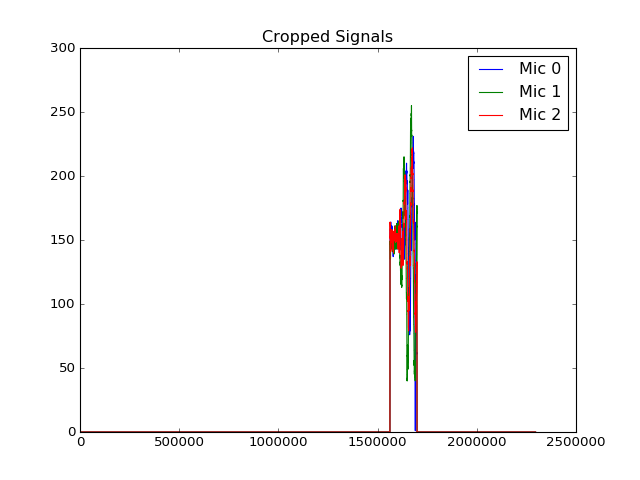

<IPython.core.display.Javascript object>


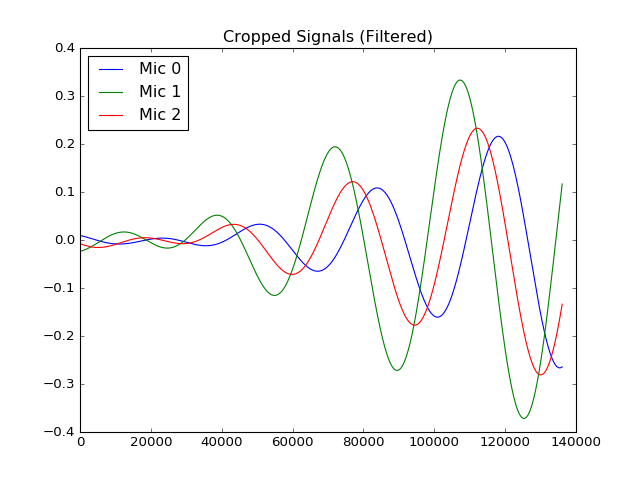

<IPython.core.display.Javascript object>


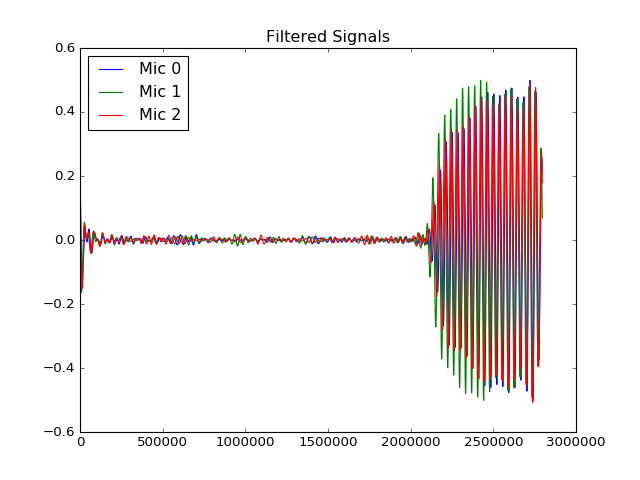

In [27]:
 # Display median filtered signals since xcorr_peaks median filters input
sigs_win = [locate.median_filter(sig) for sig in sigs_win]    

plt.figure()
plt.plot(sigs_win[0], label='Mic 0')
plt.plot(sigs_win[1], label='Mic 1')
plt.plot(sigs_win[2], label='Mic 2')
plt.title('Cropped Signals')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(sigs_butter_cropped[0], label='Mic 0')
plt.plot(sigs_butter_cropped[1], label='Mic 1')
plt.plot(sigs_butter_cropped[2], label='Mic 2')
plt.title('Cropped Signals (Filtered)')
plt.legend(loc='best')
plt.show()

plt.figure()
sig_butters = [locate.normalize_signal(
    locate.apply_ideal_bp(
        locate.FREQ_1, locate.FREQ_2, locate.SAMPLING_FREQ, sig
    )
) for sig in sigs]
plt.plot(sig_butters[0], label='Mic 0')
plt.plot(sig_butters[1], label='Mic 1')
plt.plot(sig_butters[2], label='Mic 2')
plt.title('Filtered Signals')
plt.legend(loc='best')
plt.show()

In [28]:
l = 0.3 # Length from mic to centre of array
MIC_IND_LR = {
    0: (1, 2),
    1: (2, 0),
    2: (0, 1)
}

ANGLE_OFFSET = {
    0: 0,
    1: 2.0944, # 120 deg in rad
    2: 4.18879, # 240 deg in rad
}

def calc_delays(sigs, offsets):
    """ Calculate matrix of delays given N sigs
    """
    results = []
    for j in range(len(sigs)):
        for k in range(len(sigs)):
            if j != k:
                results.append((
                        (j, k), locate.xcorr_peaks(sigs[j], sigs[k], offsets[j], offsets[k], l)
                    ))
            

    # 3x3 array delays[i][j] is the delay of signal j relative to signal i
    delays = np.zeros((len(sigs), len(sigs)), dtype=np.float)
    for res in results:
        key, val = res[0], res[1]
        delays[key[0]][key[1]] = val[1] # xcorr (val, delay) tuple
        delays[key[1]][key[0]] = -delays[key[0]][key[1]]
        
    return delays

def calc_angles(sigs, delays, l):
    """ Given delays matrix, calculate angle using far_wave
    """
    # Estimate "location" of sound source, create array record
    for j in range(len(sigs)):
        if delays[j][(j+1)%3] >= 0 and delays[j][(j+2)%3] >= 0:
            lr = MIC_IND_LR[j]
            near_pair = (min(j, lr[0]), max(j, lr[0])) if delays[j][lr[0]] < delays[j][lr[1]] else (min(j, lr[1]), max(j, lr[1]))
            print 'Near Pair: %r' %  str(near_pair)
            f_theta = np.deg2rad(farwave.calc_angle(delays, l, near_pair=near_pair))
            print 'Using microphone %d as closest mic - (%d left, %d right)' % (j, lr[0], lr[1])
            break
    
    return np.rad2deg(f_theta)


In [29]:
# Calculate delays, angle using raw signal (cropped)
delays_raw = calc_delays(sigs_cropped, offsets)
far_raw = calc_angles(sigs_cropped, delays_raw, l)

print '-----------Delays-------------'
print delays_raw
print far_raw

Near Pair: '(1, 2)'
Angles: [193.59431091744298, 143.71834574761198, 161.21611748871607]
Errors: [1.4502261327177277, 1.0922589101212632, 1.0562563426827472]

DEL_ERR: 0.357967
Error: 0.357967, 1.056256, 'False'
DEL_ERR: 0.393970
Error: 0.393970, 1.056256, 'True'
DEL_ERR: 0.036003
Error: 0.036003, 1.056256, 'True'
Setting final_ang to 161.216117
Angle (CCW): 161.216117
Using microphone 1 as closest mic - (2 left, 0 right)
-----------Delays-------------
[[     0. -10515.  -5840.]
 [ 10515.      0.   4675.]
 [  5840.  -4675.      0.]]
161.216117489


In [30]:
# Calculate delays, angle using raw signal (cropped)
delays_butter = calc_delays(sigs_butter_cropped, offsets)
far_butter = calc_angles(sigs_butter_cropped, delays_butter, l)

print '-----------Delays-------------'
print delays_butter
print far_butter

Near Pair: '(1, 2)'
Angles: [193.75432341459617, 143.03904941171433, 160.67334797751982]
Errors: [1.4459903199679376, 1.0866750014781021, 1.0597181871223957]

DEL_ERR: 0.359315
Error: 0.359315, 1.059718, 'False'
DEL_ERR: 0.386272
Error: 0.386272, 1.059718, 'True'
DEL_ERR: 0.026957
Error: 0.026957, 1.059718, 'True'
Setting final_ang to 160.673348
Angle (CCW): 160.673348
Using microphone 1 as closest mic - (2 left, 0 right)
-----------Delays-------------
[[     0. -10487.  -5682.]
 [ 10487.      0.   4805.]
 [  5682.  -4805.      0.]]
160.673347978


In [31]:
print '%f,%f' % (far_raw, far_butter)

161.216117,160.673348


<IPython.core.display.Javascript object>


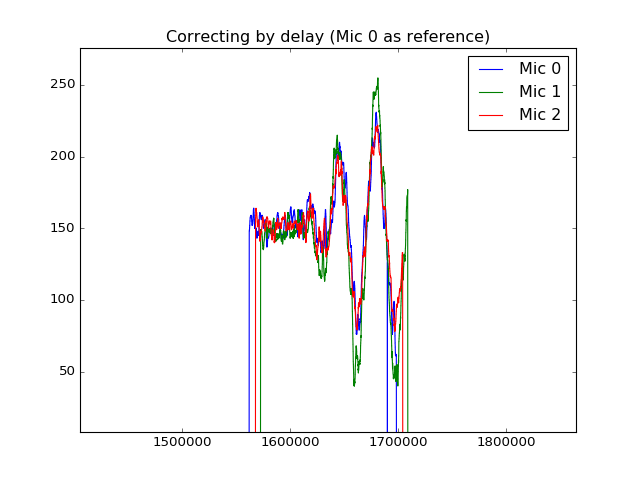

In [32]:
plt.figure()
plt.plot(np.arange(len(sigs_win[0])), sigs_win[0], label='Mic 0')
plt.plot(np.arange(len(sigs_win[1])), np.roll(sigs_win[1], -int(delays_raw[0][1])), label='Mic 1')
plt.plot(np.arange(len(sigs_win[2])), np.roll(sigs_win[2], -int(delays_raw[0][2])), label='Mic 2')
plt.legend(loc='best')
plt.title('Correcting by delay (Mic 0 as reference)')
plt.show()

<IPython.core.display.Javascript object>


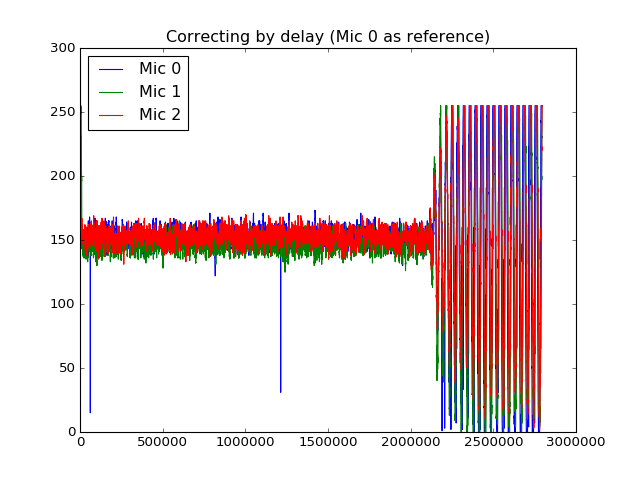

In [33]:
plt.figure()
plt.plot(np.arange(len(mic_0_med)), mic_0_med, label='Mic 0')
plt.plot(np.arange(len(mic_1_med)), np.roll(mic_1_med, -int(delays_raw[0][1])), label='Mic 1')
plt.plot(np.arange(len(mic_2_med)), np.roll(mic_2_med, -int(delays_raw[0][2])), label='Mic 2')
plt.legend(loc='best')
plt.title('Correcting by delay (Mic 0 as reference)')
plt.show()